In [31]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math

## Increasing the plot size:

In [326]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Importing the dataset

In [32]:
polish_data = pd.read_csv(r"polish_data.csv")
print(polish_data.head())

   time  delta_time        X        Y  rot  Vmps  rot_sec
0     0           0  6062445  4368335  3.8   5.2     0.13
1    11          11  6062500  4368343  5.1   5.2     0.12
2    20           9  6062556  4368351  6.3   5.2    -0.10
3    29           9  6062600  4368359  5.3   5.4     0.35
4    39          10  6062655  4368367  8.8   5.3    -0.12


## Conversion functions:

In [33]:
def deg_to_rad(deg):
    return deg*np.pi/180

def rad_to_deg(rad):
    return rad*180/np.pi

## Formulas fo the excelleration in the X and Y axis:

In [34]:
def get_mat_A(deltaTime):
    A = np.identity(4)
    A[0,2] = deltaTime
    A[1,3] = deltaTime
    return A

In [35]:
def predict_state(A, X_prev, a_x, a_y, deltaTIME):
        
    Bu_k = np.array([[a_x*deltaTIME*deltaTIME/2],
                     [a_y*deltaTIME*deltaTIME/2],
                     [a_x*deltaTIME],
                     [a_y*deltaTIME]])
    
    pred_state = A.dot(X_prev) + Bu_k
    return pred_state

## Predicting the Proccess error covariance $P_{k}^{-}$ :

In [36]:
def pred_err_cov(A, Pk, Q):
    return A.dot(Pk).dot(np.transpose(A)) + Q

## Kalman gain $K_k$ :

In [37]:
def Kalman_gain(P_k, H, R):
    above = P_k.dot(np.transpose(H))
    bottom = np.linalg.inv(H.dot(P_k).dot(np.transpose(H)) + R)
    return above.dot(bottom)

## A posteriori estimate $\hat{x}_k$ :

In [38]:
def adjust_pred_state(pred_state, Kk,z_k,H):
    #Where z_k == the real observed value to adjust for the errors made
    return pred_state + Kk.dot(z_k - H.dot(pred_state))

## Update proccess error cov $P_k$

In [39]:
def update_err_cov(I,Kk,H,P_k):
    return (I - Kk.dot(H)).dot(P_k)    

In [40]:
def calc_a_xy(arr_in, arr_prev):
    
    sog_now = arr_in[5]
    sog_prev = arr_prev[5]
    
    cog_now = arr_in[4]*np.pi/180
    cog_prev = arr_prev[4]*np.pi/180
    
    rot_now = arr_in[6]*np.pi/180
    
    delta_time = arr_in[1]
    
    a_x = (sog_now*np.cos(cog_now + rot_now*delta_time) - sog_prev*np.cos(cog_prev))/delta_time
    
    a_y = (sog_now*np.sin(cog_now + rot_now*delta_time) - sog_prev*np.sin(cog_prev))/delta_time 
    
    return a_x, a_y
    

In [41]:
def convert_state(arr_in):
    sog = arr_in[5]
    cog = arr_in[4]
    
    x = arr_in[2]
    y = arr_in[3]
    Vx = sog*np.cos(deg_to_rad(cog))
    Vy = sog*np.sin(deg_to_rad(cog))
    
    return_arr = np.array([[x],[y],[Vx],[Vy]])
    
    return return_arr

## Kalman Filter:

In [42]:

R = np.diag(np.array([1000,100,0.1,0.05]))
print(R)

[[1.e+03 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+02 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-01 0.e+00]
 [0.e+00 0.e+00 0.e+00 5.e-02]]


[]

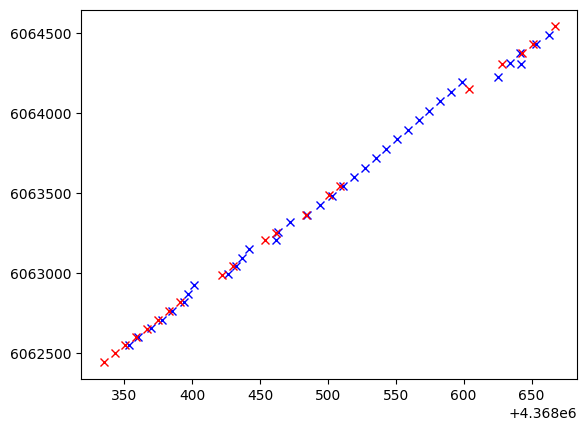

In [327]:
# Declaring the constants for Kalman filter:
A = get_mat_A(1)
P_k = np.array([[50],[10],[0.2],[0.1]]).dot(np.transpose(np.array([[50],[10],[0.2],[0.1]])))
H = np.identity(4)
I = np.identity(4)


# Sensitivity measures, deep copy to avoid address pointers:
R = np.diag(np.array([5,5,-0.8,-0.8]))
R = np.diag(np.array([20,20,0.3,0.3]))

Q = copy.deepcopy(P_k)

# Kalman Initial state
X_state = np.array([[0],[0],[0],[0]])
ax_arr = []
ay_arr = []

X_save_states = []
Pk_save_states = []
Pk_save_states.append(copy.deepcopy(P_k))

polish_counter = 1 # counter for the original data set obsevations
for i in range(0,380):
    
    '''If we observe the value we observe this'''
    if(polish_data.iloc[polish_counter,0] == i and polish_counter < 21):
        zk_prev = polish_data.iloc[polish_counter-1,:].values
        z_k = polish_data.iloc[polish_counter,:].values # convert to numpy array -observed value
        
        delta_TIME = copy.deepcopy(z_k[1])
            
        ax, ay = calc_a_xy(z_k,zk_prev)
        ax_arr.append(ax)
        ay_arr.append(ay)
        
        z_k = copy.deepcopy(convert_state(z_k))
       
        X_state = copy.deepcopy(convert_state(zk_prev))
        #Kalman Predict        
        X_state = copy.deepcopy(predict_state(A, X_state, ax, ay, 1))
        P_k =  copy.deepcopy(pred_err_cov(A, P_k, Q))
        
        # Measuremenet update
        Kalman_k = copy.deepcopy(Kalman_gain(P_k, H, R))
        X_state = copy.deepcopy(adjust_pred_state(X_state, Kalman_k, z_k, H))
        P_k = copy.deepcopy(update_err_cov(I, Kalman_k, H, P_k))
        
        X_save_states.append(copy.deepcopy(X_state))
        
        polish_counter += 1
        Pk_save_states.append(copy.deepcopy(P_k))
        #print(z_k, '\n')
    else:
        '''This code will be excecuted when we have no observation'''
        ay = 0
        ax = 0
        X_state = copy.deepcopy(predict_state(A, X_state, ax, ay, 1))
        P_k =  copy.deepcopy(pred_err_cov(A,P_k,Q))
        Pk_save_states.append(copy.deepcopy(P_k))
        X_save_states.append(copy.deepcopy(X_state))
        
        

# Saving the coordinates:
X_coord = []
Y_coord = []
Pk_coord  = []

X_orig = polish_data.iloc[:,2]
Y_orig = polish_data.iloc[:,3]

for i in range(0,380):
    if i > 10 and i % 10 == 0:
        X_coord.append(X_save_states[i][0][0])
        #print(X_save_states[i][0][0])
        Y_coord.append(X_save_states[i][1][0])
        Pk_coord.append(extract_long_lat_covariance(Pk_save_states[i]))

    
#plt.plot(X_coord[11:380], Y_coord[11:380], "bx")
plt.plot(Y_coord,X_coord, "bx")
plt.plot(Y_orig,X_orig, "rx")
#legend_data = bp
plt.plot()
    

In [328]:
def extract_long_lat_covariance(mat_in):
    Var1 = mat_in[0,0]
    Var2 = mat_in[1,1]
    Cov12 = mat_in[0,1]
    
    result = np.array([[Var1,Cov12],[Cov12,Var2]])
    return result
    
    

In [331]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

[[7560.2  1521.1 ]
 [1521.1   306.05]]


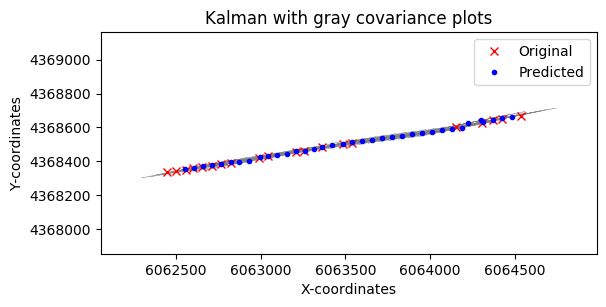

In [333]:
i_test = 2
x = X_coord[i_test]
y = [i_test]

cov = extract_long_lat_covariance(Pk_save_states[i_test])
print(cov)
lambda_, v = np.linalg.eig(cov)
lambda_ = np.sqrt(lambda_)

ax = plt.subplot(111, aspect='equal')

for obs in range(0, len(X_coord)):
    x = X_coord[obs]
    y = Y_coord[obs]
    for j in np.arange(0,4):
        ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                      width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                      angle=np.rad2deg(np.arccos(v[0, 0])), edgecolor='gray', lw=0.2, facecolor='none')
        #ell.set_facecolor('none')
        ax.add_artist(ell)
    

plt.ylim(min(Y_coord)-500,max(Y_coord)+500)
plt.xlim(min(X_coord)-500,max(X_coord)+500)
plt.plot(X_orig,Y_orig, "rx")
plt.plot(X_coord,Y_coord,'b.')

legend_data = np.array(["Original", "Predicted"])
plt.legend(legend_data, loc = 'best')
plt.title("Kalman with gray covariance plots")
plt.xlabel("X-coordinates")
plt.ylabel("Y-coordinates")

plt.show()


# plt.ylim(4368200,4368500)
# plt.xlim(6062400,6062950)


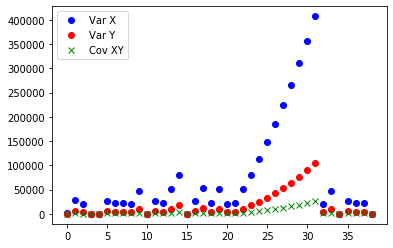

In [230]:
#Extracting variance

Var1 = []
Var2 = []
cov12 = []
for i in range(0, len(Pk_save_states)):
    if (i % 10 == 0):
        Var1.append(copy.deepcopy(extract_long_lat_covariance(Pk_save_states[i])[0][0]))
        Var2.append(copy.deepcopy(extract_long_lat_covariance(Pk_save_states[i])[0][1]))
        cov12.append(copy.deepcopy(extract_long_lat_covariance(Pk_save_states[i])[1][1]))
    
plt.plot(Var1, 'bo')
plt.plot(Var2, 'ro')
plt.plot(cov12, 'gx')

legend_data = np.array(["Var X", "Var Y", "Cov XY"])
plt.legend(legend_data, loc = 'best')

plt.show()

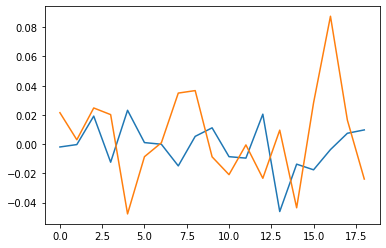

In [231]:
plt.plot(ax_arr)
plt.plot(ay_arr)

# Error Comparison:

In [75]:
len(polish_data.iloc[:,0].values)
time_intervals

NameError: name 'time_intervals' is not defined

In [ ]:
time_intervals = polish_data.iloc[:,0].values
X_pred_err = []
Y_pred_err = []

for i in range(1, len(time_intervals)):
    X_pred_err.append(X_coord[time_intervals[i]] - X_orig[i])
    Y_pred_err.append(Y_coord[time_i0n...0tervals[i]] - Y_orig[i])

plt.plot(X_pred_err)
plt.plot(Y_pred_err)
plt.ylabel('Error')
plt.xlabel('Obervation')
plt.suptitle('Error Plot of X and Y coordinates')

legend_data = np.array(["Y-coordinate", "X-coordinate"])
plt.legend(legend_data, loc = 'best')

plt.show()

In [ ]:
MSE_X = np.sum(np.array(X_pred_err)**2)/len(X_pred_err)
MSE_Y = np.sum(np.array(Y_pred_err)**2)/len(X_pred_err)
print("Mean squared error for X Coordinates: ",MSE_X)
print("Mean squared error for Y Coordinates: ",MSE_Y)

In [ ]:
np.corrcoef(X_pred_err,X_orig[1:20].values)

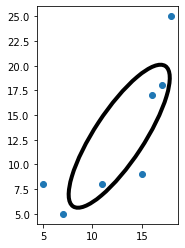

In [255]:
x = [5,7,11,15,16,17,18]
y = [8, 5, 8, 9, 17, 18, 25]
cov = np.cov(x, y)
lambda_, v = np.linalg.eig(cov)
lambda_ = np.sqrt(lambda_)
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
ax = plt.subplot(111, aspect='equal')

for j in range(1, 2):
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                  angle=np.rad2deg(np.arccos(v[0, 0])), edgecolor='black', lw=4, facecolor='none')
    
    
# ell = Ellipse(xy=[0,0], width=30, height=10, angle=0,
#               edgecolor='b', lw=4, facecolor='none')

    ax.add_artist(ell)
plt.scatter(x, y)
plt.show()